# Multiscale Spatial Metadata
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/InsightSoftwareConsortium/GetYourBrainTogether/blob/main/HCK02_2023_Allen_Institute_Hybrid/Tutorials/LargeScaleRegistration/Multiscale_Spatial_Metadata_and_Distributed_Processing.ipynb)

# Learning Objectives

- Understand the need for **spatial metadata** in OME-Zarr
    * For registration **between datasets, possibly of different types**
    * For registration with **images across scales**
- Identify the expected OME-Zarr v0.4 metadata across scales
    * `scale` coordinates should increase with increasisng scale
    * `translation` coordinates should be non-null and increase with increasing scale
- Gain experience using a few OME-Zarr libraries that generate spatial metadata
    * **multiscale-spatial-image** - Python + Xarray
    * **ngff-zarr** - Minimal Python dependencies
- Understand how to perfom processing that
    * **can limit memory usage**
    * **can be distributed**

In [1]:
import sys

!{sys.executable} -m pip install -q zarr 'ngff-zarr[cli,dask-image]' rich multiscale-spatial-image pooch tqdm matplotlib itk graphviz itkwasm

In [2]:
try:
    import google.colab
    !apt-get -y install graphviz
except ImportError:
    pass

In [3]:
from multiscale_spatial_image import to_multiscale, Methods
from spatial_image import to_spatial_image
import zarr
import pooch
import itk
from rich import print
import numpy as np
from ngff_zarr import itk_image_to_ngff_image
import json

## Spatial transformations and physical space

*Registration defines spatial transformations that define the mapping from one physical space to another physical space.*

By mapping from physical space to physical space, as opposed to voxel space to voxel, we can use the same transformation to map,

- Other data with locations defined in the physical space, such as probe positions
- Data derived from the image data, such as nuclei positions, neuron tracings
- Resampled image data, e.g. images that have been downsampled

This allows us, for example, to compute registration quality metrics with label images or fiducials (discussed in a following tutorial) or to, for example, [combine spatial transcriptomics data](https://www.biorxiv.org/content/10.1101/2023.05.05.539647v1) with structural and functional lightsheet volumes.

## Coordinate System Conversions

![ITK Registration Transforms](images/registration_transforms.svg "Registration Transforms")

Images should be correlated via their physical coordinates. This is especially important for registration.

**Note:** the static content here was taken from [Registration: Spatial Image Definitions](https://docs.google.com/presentation/d/1Mo_yHmJ7Uai2DKAO2VTyAm56V9KdI-Wx5xVgc9gljmQ/edit).

**How should multiscale image metadata be defined so it occupies the same physical space across scales?**

## ITK spacing and origin

![Origin and Spacing](images/origin_spacing.svg "Origin and Spacing")

In [4]:
file_name = pooch.retrieve('http://download.alleninstitute.org/informatics-archive/converted_mouse_ccf/average_template/average_template_25.nii.gz',
                           fname='average_template_25.nii.gz',
                           known_hash='e5ea5bb349b93577296b3b15074e11914b3dc49343cc2d9391422c4955df0947',
                           progressbar=True)

In [5]:
ccf = itk.imread(file_name)
# Since OME-Zarr does not yet support orientation, let's remove it for later comparison
ccf.SetDirection(np.eye(3))

print(ccf)

Image (0x5563d06f2e90)
  RTTI typeinfo:   itk::Image<unsigned short, 3u>
  Reference Count: 1
  Modified Time: 417
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 231
  UpdateMTime: 415
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [528, 320, 456]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [528, 320, 456]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [528, 320, 456]
  Spacing: [0.025, 0.025, 0.025]
  Origin: [0, 0, 0]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.025 0 0
0 0.025 0
0 0 0.025

  PointToIndexMatrix: 
40 0 0
0 40 0
0 0 40

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x5563d1b2f2d0)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, unsigned short>
      Reference Count: 1
      Modified Time: 412
      Debug: Off
      Object Name: 
      Observers: 
        none
      Pointer: 0x7fb581577010
      Container manages memory: true
      Size: 77045760
      Capacity: 77045760

## Original and sub-sampling grid

![Original and sub-sampling grid](images/subsampling1.svg "Original and sub-sampling grid")

## Sub-sampling grid

![Sub-sampling grid](images/subsampling2.svg "Sub-sampling grid")

In [6]:
ccf_downsampled = itk.bin_shrink_image_filter(ccf, shrink_factors=2)
print(ccf_downsampled)

Image (0x5563d1e552e0)
  RTTI typeinfo:   itk::Image<unsigned short, 3u>
  Reference Count: 1
  Modified Time: 445
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 432
  UpdateMTime: 444
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [264, 160, 228]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [264, 160, 228]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [264, 160, 228]
  Spacing: [0.05, 0.05, 0.05]
  Origin: [0.0125, 0.0125, 0.0125]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.05 0 0
0 0.05 0
0 0 0.05

  PointToIndexMatrix: 
20 0 0
0 20 0
0 0 20

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (0x5563d1c14a40)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, unsigned short>
      Reference Count: 1
      Modified Time: 442
      Debug: Off
      Object Name: 
      Observers: 
        none
      Pointer: 0x7fb57aea1010
      Container manages memory: true
      Size: 9630720
      Capacity: 9630720

In [7]:
print('full resolution')
print('size', itk.size(ccf))
print('origin', itk.origin(ccf))
print('spacing', itk.spacing(ccf))

full resolution

size itkSize3 ([528, 320, 456])

origin itkPointD3 ([0, 0, 0])

spacing itkVectorD3 ([0.025, 0.025, 0.025])

In [8]:
print('downsampled resolution')
print('size', itk.size(ccf_downsampled))
print('origin', itk.origin(ccf_downsampled))
print('spacing', itk.spacing(ccf_downsampled))

downsampled resolution

size itkSize3 ([264, 160, 228])

origin itkPointD3 ([0.0125, 0.0125, 0.0125])

spacing itkVectorD3 ([0.05, 0.05, 0.05])

In [9]:
# Compute the domain of the images given their metadata
def get_bounds(image, transform=None):
    image_bounds = [
        # Origin minus half a voxel spacing
        itk.origin(image) - 0.5*np.asarray(itk.spacing(image)),
        # Last voxel plus half a voxel spacing
        image.TransformIndexToPhysicalPoint([s - 1 for s in itk.size(image)]) + 0.5*np.asarray(itk.spacing(image)),
    ]
    return (
        [transform.TransformPoint(pt) for pt in image_bounds]
        if transform
        else image_bounds
    )


def get_physical_size(image, transform=None):
    bounds = get_bounds(image, transform)
    return np.absolute(np.array(bounds[1]) - np.array(bounds[0]))

In [10]:
print(get_bounds(ccf))
print(get_bounds(ccf_downsampled))

[itkVectorD3 ([-0.0125, -0.0125, -0.0125]), itkPointD3 ([13.1875, 7.9875, 11.3875])]

[itkVectorD3 ([-0.0125, -0.0125, -0.0125]), itkPointD3 ([13.1875, 7.9875, 11.3875])]

## OME-Zarr scale and translation

In the [previous tutorial](../OME-Zarr_Structure.ipynb), we learned that OME-Zarr is a chunked, multiscale scientific image data structure build on the Zarr format. The Zarr format is comprised of JSON-compatible metadata and multidimensional arrays stored as binary blobs.

Version 0.4 of the [OME-Zarr specification](https://ngff.openmicroscopy.org/latest/) supports three types of spatial coordinate transformations.

- `identity`
- `scale`
- `translation`

For image metadata,

- ITK `spacing` is equivalent to OME-Zarr `scale`.
- ITK `origin` is equivalent to OME-Zarr `translation`.

For multiscale OME-Zarr images,

- `scale` coordinate transformations will increase as downsampling increases
- `translation` coordinate transformation will increases as downsampling increases

since the **downsampled images occupy the same physical domain**.

## ngff-zarr

We can use the [ngff-zarr](https://pypi.org/project/ngff-zarr/) package to generate an OME-Zarr from the command line or programmically.

Observe how the scale and translation changes with scale.

In [11]:
# Call from the command line, observe information on what would be generated
!ngff-zarr -i {file_name}

╭─────────────────────────────── NGFF OME-Zarr ────────────────────────────────╮
│ ∙∙∙ Loading input...                                                         │
╭─────────────────────────────── NGFF OME-Zarr ────────────────────────────────╮
│ ∙●∙ Loading input...                                                         │
╭─────────────────────────────── NGFF OME-Zarr ────────────────────────────────╮
│ ∙∙∙ Loading input...                                                         │
╭─────────────────────────────── NGFF OME-Zarr ────────────────────────────────╮
│ ∙●∙ Loading input...                                                         │
╭─────────────────────────────── NGFF OME-Zarr ────────────────────────────────╮
│ ∙∙∙ Loading input...                                                         │
╭─────────────────────────────── NGFF OME-Zarr ────────────────────────────────╮
│ ∙∙∙ Loading input...                                                         │
╭───────────────────────────

In [12]:
ngff_image = itk_image_to_ngff_image(ccf)
print(ngff_image)

NgffImage(
    data=dask.array<array, shape=(456, 320, 528), dtype=uint16, chunksize=(456, 320, 459), 
chunktype=numpy.ndarray>,
    dims=('z', 'y', 'x'),
    scale={'z': 0.02500000037252903, 'y': 0.02500000037252903, 'x': 0.02500000037252903},
    translation={'z': 0.0, 'y': 0.0, 'x': 0.0},
    name='image',
    axes_units=None
)

In [13]:
from ngff_zarr import to_multiscales as ngff_image_to_multiscales
multiscales = ngff_image_to_multiscales(ngff_image)
print(multiscales)

Multiscales(
    images=[
        NgffImage(
            data=dask.array<rechunk-merge, shape=(456, 320, 528), dtype=uint16, chunksize=(128, 128, 128), 
chunktype=numpy.ndarray>,
            dims=('z', 'y', 'x'),
            scale={'z': 0.02500000037252903, 'y': 0.02500000037252903, 'x': 0.02500000037252903},
            translation={'z': 0.0, 'y': 0.0, 'x': 0.0},
            name='image',
            axes_units=None
        ),
        NgffImage(
            data=dask.array<rechunk-merge, shape=(228, 160, 264), dtype=uint16, chunksize=(128, 128, 128), 
chunktype=numpy.ndarray>,
            dims=('z', 'y', 'x'),
            scale={'z': 0.05000000074505806, 'y': 0.05000000074505806, 'x': 0.05000000074505806},
            translation={'z': 0.012500000186264515, 'y': 0.012500000186264515, 'x': 0.012500000186264515},
            name='image',
            axes_units=None
        ),
        NgffImage(
            data=dask.array<rechunk-merge, shape=(228, 160, 132), dtype=uint16, chunksize=(128, 128, 128), 
chunktype=numpy.ndarray>,
            dims=('z', 'y', 'x'),
            scale={'z': 0.05000000074505806, 'y': 0.05000000074505806, 'x': 0.10000000149011612},
            translation={'z': 0.012500000186264515, 'y': 0.012500000186264515, 'x': 0.037500000558793545},
            name='image',
            axes_units=None
        )
    ],
    metadata=Metadata(
        axes=[
            Axis(name='z', type='space', unit=None),
            Axis(name='y', type='space', unit=None),
            Axis(name='x', type='space', unit=None)
        ],
        datasets=[
            Dataset(
                path='scale0/image',
                coordinateTransformations=[
                    Scale(scale=[0.02500000037252903, 0.02500000037252903, 0.02500000037252903], type='scale'),
                    Translation(translation=[0.0, 0.0, 0.0], type='translation')
                ]
            ),
            Dataset(
                path='scale1/image',
                coordinateTransformations=[
                    Scale(scale=[0.05000000074505806, 0.05000000074505806, 0.05000000074505806], type='scale'),
                    Translation(
                        translation=[0.012500000186264515, 0.012500000186264515, 0.012500000186264515],
                        type='translation'
                    )
                ]
            ),
            Dataset(
                path='scale2/image',
                coordinateTransformations=[
                    Scale(scale=[0.05000000074505806, 0.05000000074505806, 0.10000000149011612], type='scale'),
                    Translation(
                        translation=[0.012500000186264515, 0.012500000186264515, 0.037500000558793545],
                        type='translation'
                    )
                ]
            )
        ],
        name='image',
        version='0.4',
        coordinateTransformations=[]
    ),
    scale_factors=[{'x': 2, 'z': 2, 'y': 2}, {'x': 4, 'z': 2, 'y': 2}],
    method=<Methods.DASK_IMAGE_GAUSSIAN: 'dask_image_gaussian'>,
    chunks={'z': 128, 'y': 128, 'x': 128}
)

In [14]:
from ngff_zarr import ngff_image_to_itk_image

for scale, image in enumerate(multiscales.images):
    itk_image = ngff_image_to_itk_image(image, False)
    print(scale, get_bounds(itk_image))

0
[itkVectorD3 ([-0.0125, -0.0125, -0.0125]), itkPointD3 ([13.1875, 7.9875, 11.3875])]

1
[itkVectorD3 ([-0.0125, -0.0125, -0.0125]), itkPointD3 ([13.1875, 7.9875, 11.3875])]

2
[itkVectorD3 ([-0.0125, -0.0125, -0.0125]), itkPointD3 ([13.1875, 7.9875, 11.3875])]

## multiscale-spatial-image

Another option is to use [multiscale-spatial-image](https://github.com/spatial-image/multiscale-spatial-image) library. Instead of Python dataclasses, this library uses [Xarray](https://docs.xarray.dev) data structures.

In Xarray, spatial coordinates are associated with the array indices. And names, `"x"`, `"y"` for example, identify both pixel array dimensions and their associated coordinates.

In [15]:
# Convert from an itk.Image to an xarray.DataArray
ccf_spatial_image = itk.xarray_from_image(ccf)
# Remove attrs that cannot be serialized to OME-Zarr
ccf_spatial_image.attrs.clear()

print(ccf_spatial_image)

<xarray.DataArray 'image' (z: 456, y: 320, x: 528)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * x        (x) float64 0.0 0.025 0.05 0.075 0.1 ... 13.1 13.13 13.15 13.18
  * y        (y) float64 0.0 0.025 0.05 0.075 0.1 ... 7.875 7.9 7.925 7.95 7.975
  * z        (z) float64 0.0 0.025 0.05 0.075 0.1 ... 11.3 11.33 11.35 11.38

In [16]:
multiscales = to_multiscale(ccf_spatial_image, scale_factors=[2, 2])
print(multiscales)

DataTree('None', parent=None)
├── DataTree('scale0')
│       Dimensions:  (x: 528, y: 320, z: 456)
│       Coordinates:
│         * x        (x) float64 0.0 0.025 0.05 0.075 0.1 ... 13.1 13.13 13.15 13.18
│         * y        (y) float64 0.0 0.025 0.05 0.075 0.1 ... 7.875 7.9 7.925 7.95 7.975
│         * z        (z) float64 0.0 0.025 0.05 0.075 0.1 ... 11.3 11.33 11.35 11.38
│       Data variables:
│           image    (z, y, x) uint16 dask.array<chunksize=(64, 64, 64), meta=np.ndarray>
├── DataTree('scale1')
│       Dimensions:  (x: 264, y: 160, z: 228)
│       Coordinates:
│         * x        (x) float64 0.0125 0.0625 0.1125 0.1625 ... 13.01 13.06 13.11 13.16
│         * y        (y) float64 0.0125 0.0625 0.1125 0.1625 ... 7.813 7.863 7.913 7.963
│         * z        (z) float64 0.0125 0.0625 0.1125 0.1625 ... 11.21 11.26 11.31 11.36
│       Data variables:
│           image    (z, y, x) uint16 dask.array<chunksize=(64, 64, 64), meta=np.ndarray>
└── DataTree('scale2')
        Dimensions:  (x: 132, y: 80, z: 114)
        Coordinates:
          * x        (x) float64 0.0375 0.1375 0.2375 0.3375 ... 12.84 12.94 13.04 13.14
          * y        (y) float64 0.0375 0.1375 0.2375 0.3375 ... 7.638 7.738 7.838 7.938
          * z        (z) float64 0.0375 0.1375 0.2375 0.3375 ... 11.04 11.14 11.24 11.34
        Data variables:
            image    (z, y, x) uint16 dask.array<chunksize=(64, 64, 64), meta=np.ndarray>

In [17]:
store = dict()

multiscales.to_zarr(store)

ome_metadata = json.loads(store.get('.zattrs').decode())['multiscales']
print(ome_metadata)

[
    {
        '@type': 'ngff:Image',
        'axes': [{'name': 'x', 'type': 'space'}, {'name': 'y', 'type': 'space'}, {'name': 'z', 'type': 'space'}],
        'datasets': [
            {
                'coordinateTransformations': [
                    {'scale': [0.02500000037252903, 0.02500000037252903, 0.02500000037252903], 'type': 'scale'},
                    {'translation': [0.0, 0.0, 0.0], 'type': 'translation'}
                ],
                'path': 'scale0/image'
            },
            {
                'coordinateTransformations': [
                    {'scale': [0.05000000074505806, 0.05000000074505806, 0.05000000074505806], 'type': 'scale'},
                    {
                        'translation': [0.012500000186264515, 0.012500000186264515, 0.012500000186264515],
                        'type': 'translation'
                    }
                ],
                'path': 'scale1/image'
            },
            {
                'coordinateTransformations': [
                    {'scale': [0.10000000149011612, 0.10000000149011612, 0.10000000149011612], 'type': 'scale'},
                    {
                        'translation': [0.037500000558793545, 0.037500000558793545, 0.037500000558793545],
                        'type': 'translation'
                    }
                ],
                'path': 'scale2/image'
            }
        ],
        'name': 'image',
        'version': '0.4'
    }
]

In [18]:
for scale in range(len(multiscales)):
    itk_image = itk.image_from_xarray(multiscales[f'scale{scale}'].image)
    print(scale, get_bounds(itk_image))

0
[itkVectorD3 ([-0.0125, -0.0125, -0.0125]), itkPointD3 ([13.1875, 7.9875, 11.3875])]

1
[itkVectorD3 ([-0.0125, -0.0125, -0.0125]), itkPointD3 ([13.1875, 7.9875, 11.3875])]

2
[itkVectorD3 ([-0.0125, -0.0125, -0.0125]), itkPointD3 ([13.1875, 7.9875, 11.3875])]

## Exercises

### Exercise 1: Select data with xarray

With Xarray, data can be selected through indexed slicing as in NumPy.



However, data can also be selected by coordinate label. by explicit dimension names. For example, to select the plane at z
Could the keys generated by our original multiscales zarr serialization. Why might a large number of keys cause a problems when stored as a directory store? 

In [19]:
scale0 = multiscales['scale0'].image
print(scale0)

<xarray.DataArray 'image' (z: 456, y: 320, x: 528)>
dask.array<xarray-<this-array>, shape=(456, 320, 528), dtype=uint16, chunksize=(64, 64, 64), 
chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0 0.025 0.05 0.075 0.1 ... 13.1 13.13 13.15 13.18
  * y        (y) float64 0.0 0.025 0.05 0.075 0.1 ... 7.875 7.9 7.925 7.95 7.975
  * z        (z) float64 0.0 0.025 0.05 0.075 0.1 ... 11.3 11.33 11.35 11.38

In [20]:
scale0

<xarray.DataArray 'image' (z: 456, y: 320, x: 528)>
dask.array<xarray-<this-array>, shape=(456, 320, 528), dtype=uint16, chunksize=(64, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0 0.025 0.05 0.075 0.1 ... 13.1 13.13 13.15 13.18
  * y        (y) float64 0.0 0.025 0.05 0.075 0.1 ... 7.875 7.9 7.925 7.95 7.975
  * z        (z) float64 0.0 0.025 0.05 0.075 0.1 ... 11.3 11.33 11.35 11.38

In [21]:
print(scale0[200,...])

<xarray.DataArray 'image' (y: 320, x: 528)>
dask.array<getitem, shape=(320, 528), dtype=uint16, chunksize=(64, 64), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0 0.025 0.05 0.075 0.1 ... 13.1 13.13 13.15 13.18
  * y        (y) float64 0.0 0.025 0.05 0.075 0.1 ... 7.875 7.9 7.925 7.95 7.975
    z        float64 5.0

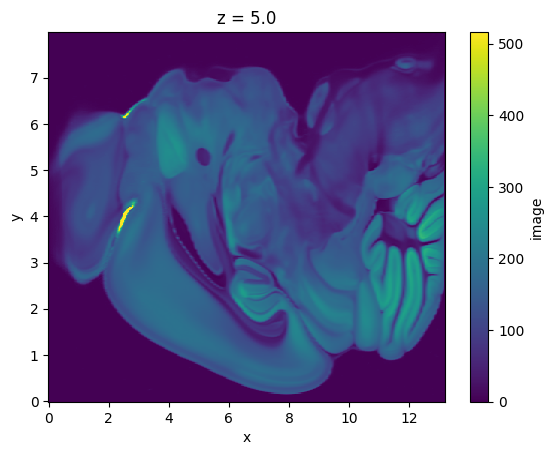

In [22]:
scale0[200,...].plot()

We can also index directly by dimension name, which is helpful to avoid errors related to dimension ordering.

In [23]:
print(scale0.isel(z=200))

<xarray.DataArray 'image' (y: 320, x: 528)>
dask.array<getitem, shape=(320, 528), dtype=uint16, chunksize=(64, 64), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0 0.025 0.05 0.075 0.1 ... 13.1 13.13 13.15 13.18
  * y        (y) float64 0.0 0.025 0.05 0.075 0.1 ... 7.875 7.9 7.925 7.95 7.975
    z        float64 5.0

In [24]:
scale0.isel(z=200)

<xarray.DataArray 'image' (y: 320, x: 528)>
dask.array<getitem, shape=(320, 528), dtype=uint16, chunksize=(64, 64), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0 0.025 0.05 0.075 0.1 ... 13.1 13.13 13.15 13.18
  * y        (y) float64 0.0 0.025 0.05 0.075 0.1 ... 7.875 7.9 7.925 7.95 7.975
    z        float64 5.0

But we can also select data by coordinate value.

In [25]:
print(scale0.sel(z=5.0, method='nearest'))

<xarray.DataArray 'image' (y: 320, x: 528)>
dask.array<getitem, shape=(320, 528), dtype=uint16, chunksize=(64, 64), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0 0.025 0.05 0.075 0.1 ... 13.1 13.13 13.15 13.18
  * y        (y) float64 0.0 0.025 0.05 0.075 0.1 ... 7.875 7.9 7.925 7.95 7.975
    z        float64 5.0

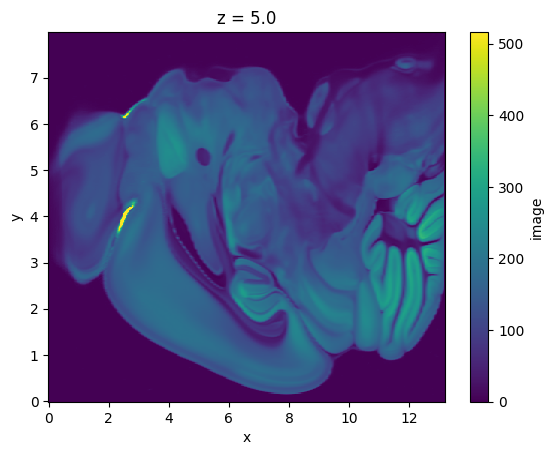

In [26]:
scale0.sel(z=5.0, method='nearest').plot()

Plot the plane at z=8.0.

How does defining the location of a pixel at its center simplify this?

### Exercise 2: Multiscale metadata

Plot the data at z=8.0 for scale1 and scale2. Have the extent of the axes changed?

In [27]:
scale1 = multiscales['scale1'].image
print(scale1)
scale2 = multiscales['scale2'].image
print(scale2)

<xarray.DataArray 'image' (z: 228, y: 160, x: 264)>
dask.array<rechunk-merge, shape=(228, 160, 264), dtype=uint16, chunksize=(64, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0125 0.0625 0.1125 0.1625 ... 13.01 13.06 13.11 13.16
  * y        (y) float64 0.0125 0.0625 0.1125 0.1625 ... 7.813 7.863 7.913 7.963
  * z        (z) float64 0.0125 0.0625 0.1125 0.1625 ... 11.21 11.26 11.31 11.36

<xarray.DataArray 'image' (z: 114, y: 80, x: 132)>
dask.array<rechunk-merge, shape=(114, 80, 132), dtype=uint16, chunksize=(64, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0375 0.1375 0.2375 0.3375 ... 12.84 12.94 13.04 13.14
  * y        (y) float64 0.0375 0.1375 0.2375 0.3375 ... 7.638 7.738 7.838 7.938
  * z        (z) float64 0.0375 0.1375 0.2375 0.3375 ... 11.04 11.14 11.24 11.34

## Exercise 3: Selecting regions by spatial location

In [28]:
scale0.sel(x=slice(4.0, 10.0))

<xarray.DataArray 'image' (z: 456, y: 320, x: 240)>
dask.array<getitem, shape=(456, 320, 240), dtype=uint16, chunksize=(64, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 4.0 4.025 4.05 4.075 4.1 ... 9.875 9.9 9.925 9.95 9.975
  * y        (y) float64 0.0 0.025 0.05 0.075 0.1 ... 7.875 7.9 7.925 7.95 7.975
  * z        (z) float64 0.0 0.025 0.05 0.075 0.1 ... 11.3 11.33 11.35 11.38

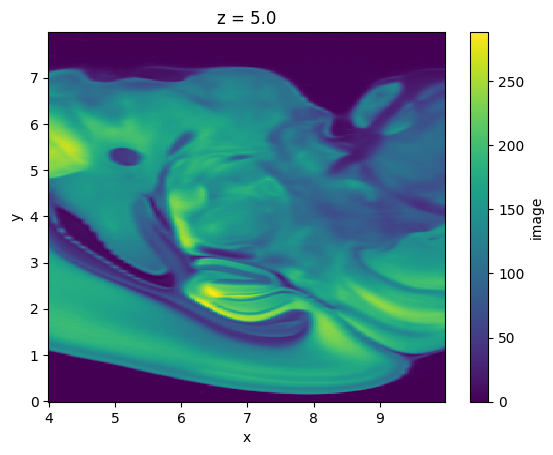

In [29]:
scale0.sel(x=slice(4.0, 10.0)).sel(z=5.0, method='nearest').plot()

Select the same region in `scale1`.

## Exercise 4: Incremental processing

In [30]:
scale1

<xarray.DataArray 'image' (z: 228, y: 160, x: 264)>
dask.array<rechunk-merge, shape=(228, 160, 264), dtype=uint16, chunksize=(64, 64, 64), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.0125 0.0625 0.1125 0.1625 ... 13.01 13.06 13.11 13.16
  * y        (y) float64 0.0125 0.0625 0.1125 0.1625 ... 7.813 7.863 7.913 7.963
  * z        (z) float64 0.0125 0.0625 0.1125 0.1625 ... 11.21 11.26 11.31 11.36

Our data is chunked into blocks that can be processed in-memory at a given scale.

We can execute a function to process each one of the chunk with `map_blocks`.

Here we apply a simple filter. For registration, our function is a registration function that registers the current chunk against a region in the target image (the current registration domain extended with a buffer that can account for expected translations or warping).

In [31]:
processed = scale2.map_blocks(itk.median_image_filter)

The above cell executes very quickly?

Why?

Computation was not actually perform. However a computional task graph is generated that defines the sequence of steps to produce the result.

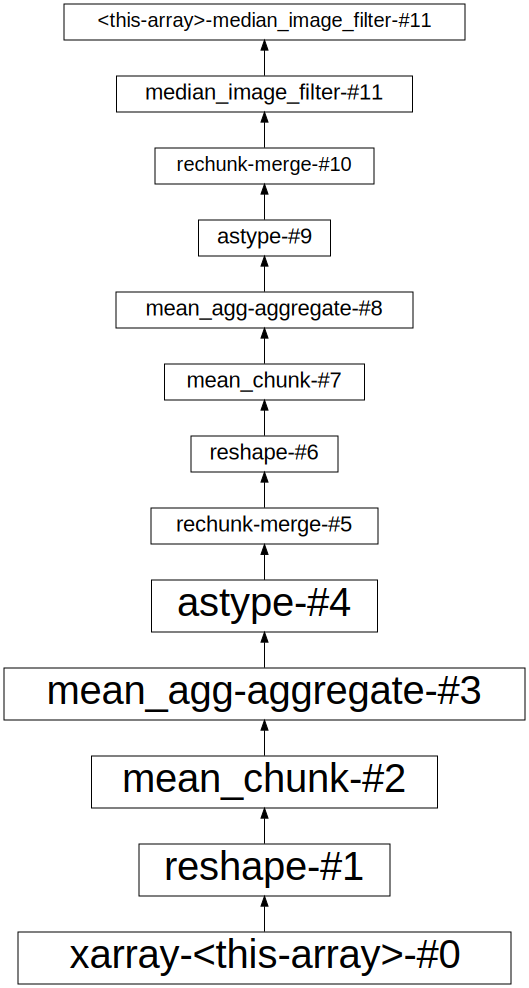

In [32]:
processed.data.dask.visualize()

This sequence can be applied to each block independently. This enables limits on processing memory consumption. Each subgraph can also be distributed to multiple computational nodes.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.295552 to fit


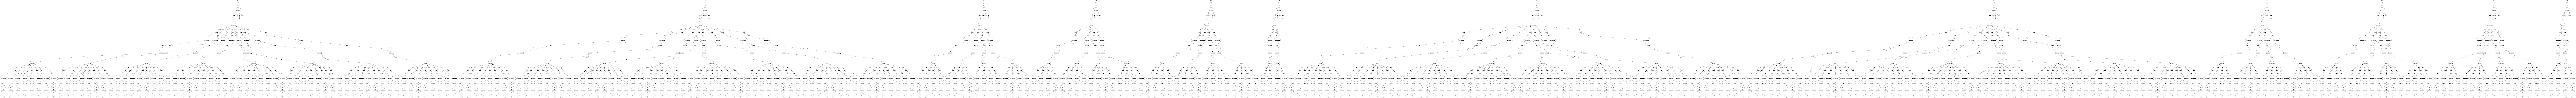

In [33]:
processed.data.visualize()

To perform the processing, we can call `compute`. However, this will load the result in memory.

In [34]:
processed.compute()

<xarray.DataArray 'image' (z: 114, y: 80, x: 132)>
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 1, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 1, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 1, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 1, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint16)
Coordinates:
  * x        (x) float64 0.0375 0.1375 0.2375 0.3375 ... 12.84 12.94 13.04 13.14
  * z        (z) float64 0.0375 0.1375 0.2375 0.3375 ... 11.04 11.14 11.24 11.34
  * y        (y) float64 0.0375 0.1375 0.2375 0.3375 ... 7.638 7.738 7.838 7.938
Attributes:
    direction:  [[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]

Instead, if we wish to process each block without loading all the data in memory, we can go from *zarr* to *zarr*.

In [35]:
processed_multiscales = to_multiscale(processed, scale_factors=[1])
processed_multiscales.to_zarr('processed.zarr', compute=True)

Apply the same processing to `scale2`. What will be different?